In [5]:
import torch
import pandas as pd
import os

def prepare_training_data(attribute):
    # Paths
    latents_path = f"../outputs/latents/latents_{attribute}_output/latents.pt"
    labels_csv = f"../data/feature_based/{attribute}_df.csv"

    # Load
    w_plus = torch.load(latents_path)  # shape: [N, 18, 512]
    latents = w_plus.mean(dim=1)       # → average across 18 layers → [N, 512]

    df = pd.read_csv(labels_csv)
    labels = df[attribute].values.tolist()
    filenames = df['filename'].tolist()

    assert len(latents) == len(labels) == len(filenames), "Mismatch in data lengths!"

    # Save dataset
    dataset = {
        'latents': latents,  # [N, 512]
        'labels': torch.tensor(labels),
        'filenames': filenames,
        'attribute': attribute
    }

    save_path = f"../data/svm_training_data/{attribute}_train_data.pt"
    torch.save(dataset, save_path)
    print(f"✅ Saved: {save_path} ({len(latents)} samples)")


In [6]:
for attr in ['smiling', 'blond_hair', 'bald', 'eyeglasses', 'beard']:
    prepare_training_data(attr)


✅ Saved: training_data/smiling_train_data.pt (1000 samples)
✅ Saved: training_data/blond_hair_train_data.pt (1000 samples)
✅ Saved: training_data/bald_train_data.pt (1000 samples)
✅ Saved: training_data/eyeglasses_train_data.pt (1000 samples)
✅ Saved: training_data/beard_train_data.pt (1000 samples)


# Training SVM

In [6]:
import torch
from sklearn.svm import LinearSVC

attribute_directions = {}

for attr in ['smiling', 'blond_hair', 'bald', 'eyeglasses', 'beard']:
    data = torch.load(f'../data/svm_training_data/{attr}_train_data.pt')
    X = data['latents'].cpu().numpy()
    y = data['labels'].cpu().numpy()

    clf = LinearSVC(C=1.0, max_iter=10000)
    clf.fit(X, y)

    direction = clf.coef_.flatten()  # shape: [512]
    attribute_directions[attr] = torch.tensor(direction)

# Save all directions together
torch.save(attribute_directions, '../outputs/directions/svm/attribute_directions_svm.pt')
print("✅ Saved latent directions to attribute_directions_svm.pt")


✅ Saved latent directions to attribute_directions.pt


# GanSpace Unsupervised Approach

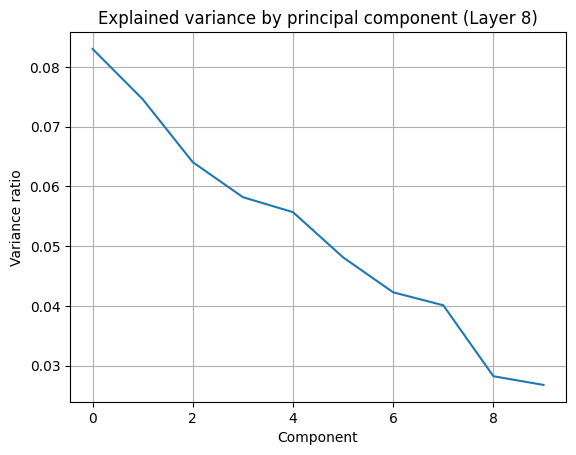

In [19]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load latents (assumes shape [N, 18, 512])
w_plus = torch.load("../outputs/latents/pca_latents/latents.pt")  # or .cpu()
w_plus = w_plus['latents'].cpu().numpy()

# Extract layer 8 only
w_layer8 = w_plus[:, 8, :]  # shape: [N, 512]

# Run PCA
pca = PCA(n_components=10)
w_pca = pca.fit_transform(w_layer8)

# Plot explained variance
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance by principal component (Layer 8)")
plt.xlabel("Component")
plt.ylabel("Variance ratio")
plt.grid(True)
plt.show()

# Save the components
torch.save({
    'components': torch.tensor(pca.components_),    # shape: [10, 512]
    'mean': torch.tensor(pca.mean_),
    'explained_variance': torch.tensor(pca.explained_variance_)
}, '../outputs/directions/pca/attribute_directions_pca.pt')
